## Семинар 6: "Архитектуры и transfer learning"

ФИО:

In [1]:
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F

from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL.Image

%matplotlib inline

Часть 1: Реализуйте Deep Dream

https://github.com/google/deepdream/blob/master/dream.ipynb
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [2]:
class SlicedVGG:
    def __init__(self, model=None):
        if model is None:
            model = models.vgg16(pretrained=True)
        self.model = model
    
    def forward(self, x, to_layer):
        for i in range(to_layer):
            x = self.model.features[i](x)
        return x

In [3]:
class SlicedResnet:
    def __init__(self, model=None):
        if model is None:
            model = models.resnet152(pretrained=True)
        self.model = model
        
    def forward(self, x, end_layer):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        
        layers = [self.model.layer1, self.model.layer2, self.model.layer3, self.model.layer4]
        for i in range(end_layer):
            x = layers[i](x)
        return x

In [4]:
class SlicedInception3:
    def __init__(self, inception=None):
        if inception is None:
            inception = models.inception_v3(pretrained=True)
        self.model = inception
        
    def _init_layer_counter(self):
        self._curr_layer = 0
        
    def _should_return(self, end_layer):
        self._curr_layer += 1
        if self._curr_layer == end_layer:
            return True
        return False
        
    def forward(self, x, end_layer):
        # 299 x 299 x 3
        self._init_layer_counter()
        x = self.model.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        if (self._should_return(end_layer)):
            return x
        x = self.model.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        if (self._should_return(end_layer)):
            return x
        x = self.model.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        if (self._should_return(end_layer)):
            return x
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        if (self._should_return(end_layer)):
            return x
        x = self.model.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        if (self._should_return(end_layer)):
            return x
        x = self.model.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        if (self._should_return(end_layer)):
            return x
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_5b(x)
        # 35 x 35 x 256
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_5c(x)
        # 35 x 35 x 288
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_5d(x)
        # 35 x 35 x 288
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_6a(x)
        # 17 x 17 x 768
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_6b(x)
        # 17 x 17 x 768
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_6c(x)
        # 17 x 17 x 768
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_6d(x)
        # 17 x 17 x 768
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_6e(x)
        # 17 x 17 x 768
        if (self._should_return(end_layer)):
            return x
        if self.model.training and self.model.aux_logits:
            aux = self.model.AuxLogits(x)
        # 17 x 17 x 768
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_7a(x)
        # 8 x 8 x 1280
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_7b(x)
        # 8 x 8 x 2048
        if (self._should_return(end_layer)):
            return x
        x = self.model.Mixed_7c(x)
        # 8 x 8 x 2048
        if (self._should_return(end_layer)):
            return x
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        if (self._should_return(end_layer)):
            return x
        x = F.dropout(x, training=self.model.training)
        # 1 x 1 x 2048
        print('[SlicedInception3] last layer reached.')
        return x
        x = x.view(x.size(0), -1)
        # 2048
        x = self.model.fc(x)
        # 1000 (num_classes)
        if self.model.training and self.model.aux_logits:
            return x, aux
        return x

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

img_transform = transforms.Compose([
    transforms.Scale(224),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [6]:
def revert_normalize(img, mean=mean, std=std):
    res = img.copy()
    for c in range(3):
        res[c, :, :] = res[c, :, :] * std[c] + mean[c]
    res = res.clip(min=0, max=1)
    return res

def show_img(img, rescale=False):
    a = 0
    if rescale:
        a = (img - np.min(img)) / (np.max(img) - np.min(img))
    else:
        a = revert_normalize(img)
    a = np.rollaxis(a, 0, 3)
    a = np.uint8(np.clip(a, 0, 1)*255)
    
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, 'jpeg')
    display(Image(data=f.getvalue()))

In [15]:
## Laplacian Pyramid Gradient Normalization
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)
k5x5 = np.rollaxis(k5x5, 3)
k5x5 = np.rollaxis(k5x5, 3)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    h_o_p = int((img.shape[2] + 1) % 2)
    w_o_p = int((img.shape[3] + 1) % 2)
    pads = (h_o_p, w_o_p)
    img_v = Variable(torch.from_numpy(img)).float()
    conv = nn.Conv2d(3, 3, kernel_size=5, stride=2)
    conv.bias.data.zero_()
    conv.weight.data.zero_()
    conv.weight.data += torch.from_numpy(k5x5)
    lo = conv(img_v)
    conv_t = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=2, output_padding=pads)
    conv_t.bias.data.zero_()
    conv_t.weight.data.zero_()
    conv_t.weight.data += torch.from_numpy(k5x5*4)
    lo2 = conv_t(lo)
    hi = img_v - lo2
    return lo.data.numpy(), hi.data.numpy(), pads

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    std = np.sqrt(np.mean(img ** 2)) # what about mean?
    return img / (std + eps)

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    pads = []
    for i in range(n):
        img, hi, pd = lap_split(img)
        levels.append(hi)
        pads.append(pd)
    levels.append(img)
    levels = list(map(normalize_std, levels))
    return levels[::-1], pads[::-1]

def lap_merge(levels, pads):
    '''Merge Laplacian pyramid'''
    img = Variable(torch.from_numpy(levels[0]))
    conv_t = nn.ConvTranspose2d(3, 3, kernel_size=5, stride=2)
    conv_t.bias.data.zero_()
    conv_t.weight.data.zero_()
    conv_t.weight.data += torch.from_numpy(k5x5*4)
    for hi, pd in zip(levels[1:], pads):
        conv_t.output_padding = pd
        img = conv_t(img) + Variable(torch.from_numpy(hi))
    return img

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    tlevels, pads = lap_split_n(img, scale_n)
#     tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels, pads)
    return out.data.numpy()


side = 224
im = np.random.randn(1, 3, side, side)*0.1+0.3

In [25]:
def calc_grad_tiled(img, model, channel, end_layer, tile_size=224):
    sz = tile_size
    h, w = img.shape[-2:]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 3), sy, 2)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[:,:,y:y+sz,x:x+sz]
            img_target = Variable(torch.from_numpy(sub), requires_grad=True).float().cuda()
            out_target = model.forward(img_target, end_layer)[:, channel, :, :]
            diff_out = torch.mean(out_target)
            g = torch.autograd.grad(diff_out, img_target)[0].data.cpu().numpy()
            grad[:,:,y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 3), -sy, 2)

def dream(model, img, lr=1.0, end_layer=25,
          channel=0, n_iter=20, show_every=5,
          n_octave=3, octave_scale=1.4):

    model.model = model.model.cuda()

#     model.model.require_gradients = False
    for octave in range(n_octave):
        if octave > 0:
            h = int(img.shape[-2] * octave_scale)
            w = int(img.shape[-1] * octave_scale)
            img = nn.Upsample(size=(h, w), mode='bilinear')(Variable(torch.from_numpy(img))).data.numpy()
        for i in range(n_iter):
            g = calc_grad_tiled(img, sliced, channel, end_layer)
            g = lap_normalize(g)
            g /= np.std(g) + 1e-4
        
            img += g * lr
        
            if i % show_every == 0:
                print('Octave: {}, iter: {}'.format(octave, i))
                show_img(img[0])

In [34]:
vgg = models.vgg19(pretrained=True)
# resnet = models.resnet50(pretrained=True)

Octave: 0, iter: 0


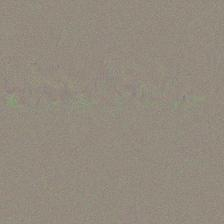

Octave: 0, iter: 15


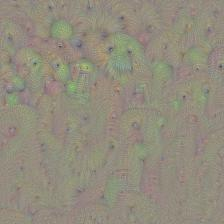

Octave: 0, iter: 30


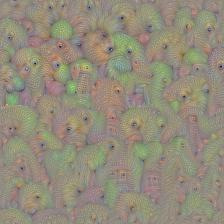

Octave: 0, iter: 45


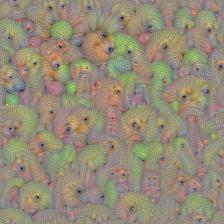

Octave: 0, iter: 60


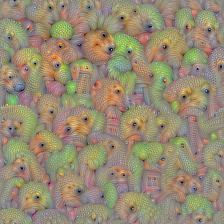

Octave: 1, iter: 0


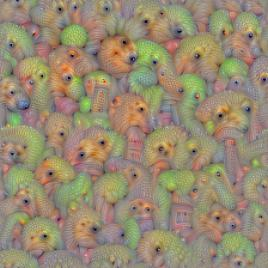

Octave: 1, iter: 15


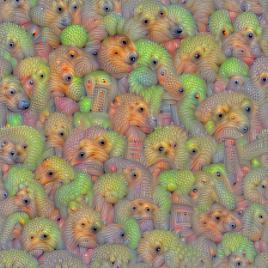

Octave: 1, iter: 30


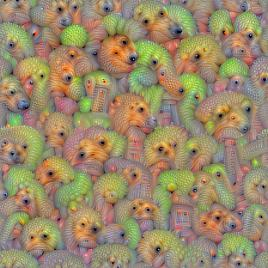

Octave: 1, iter: 45


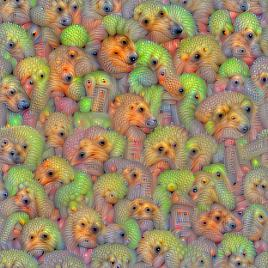

Octave: 1, iter: 60


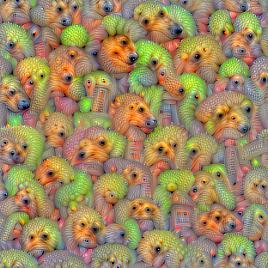

Octave: 2, iter: 0


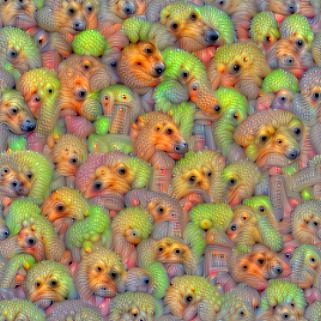

Octave: 2, iter: 15


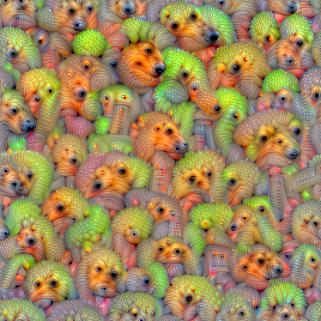

Octave: 2, iter: 30


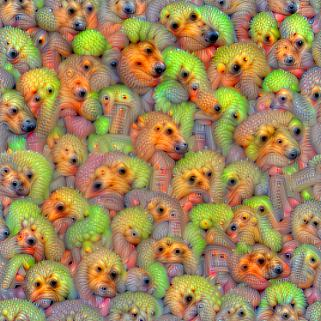

Octave: 2, iter: 45


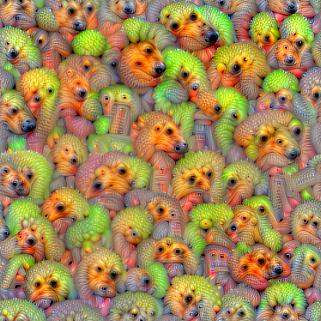

Octave: 2, iter: 60


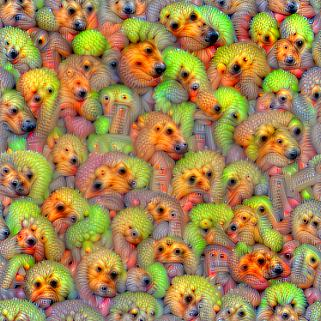

In [58]:
sliced = SlicedVGG(vgg)
# sliced = SlicedInception3()
# sliced = SlicedResnet(resnet)

side = 224
img = np.random.randn(1, 3, side, side)*0.1+0.4
dream(sliced, img, lr=0.02, channel=123, end_layer=30, n_iter=65, show_every=15, n_octave=3, octave_scale=1.2)


Octave: 0, iter: 0


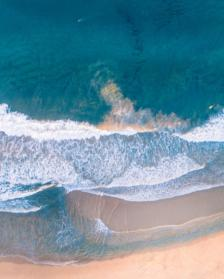

Octave: 0, iter: 15


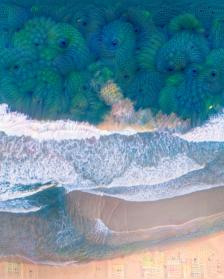

Octave: 0, iter: 30


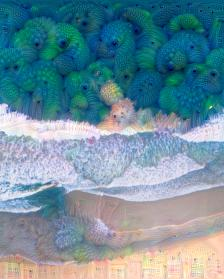

Octave: 0, iter: 45


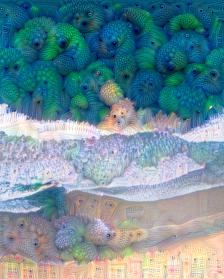

Octave: 0, iter: 60


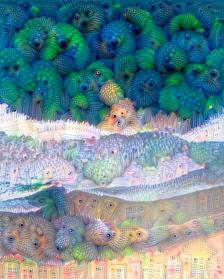

Octave: 1, iter: 0


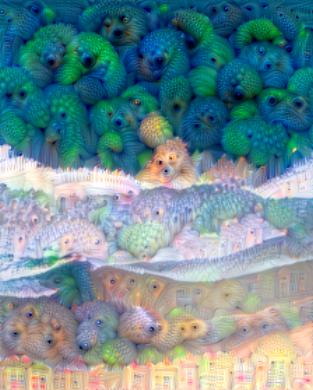

Octave: 1, iter: 15


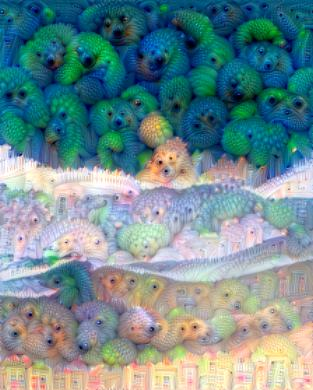

Octave: 1, iter: 30


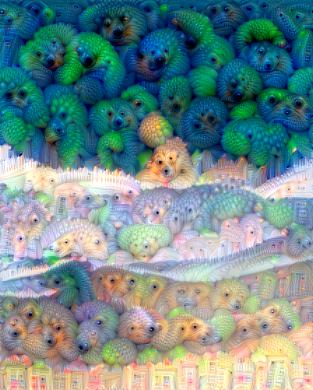

Octave: 1, iter: 45


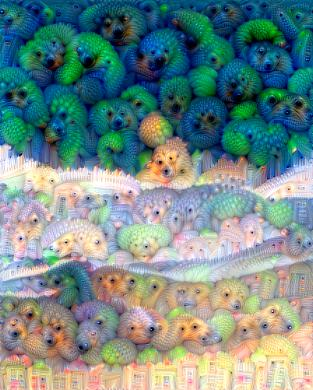

Octave: 1, iter: 60


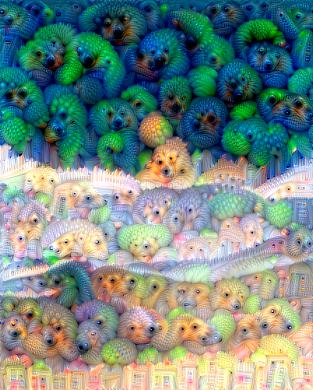

Octave: 2, iter: 0


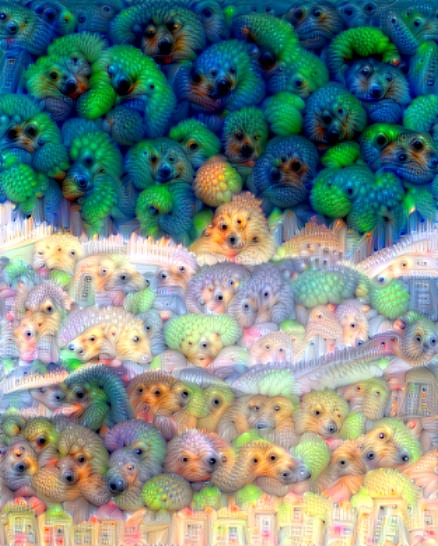

Octave: 2, iter: 15


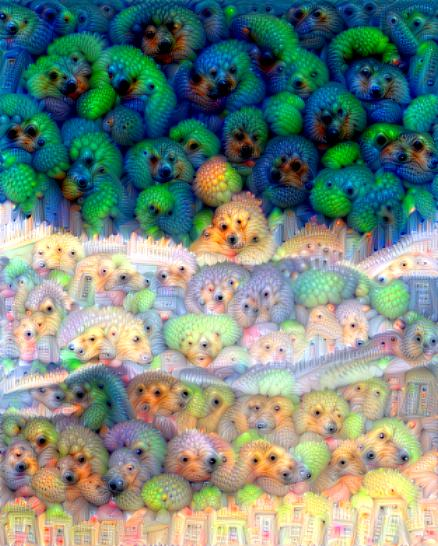

Octave: 2, iter: 30


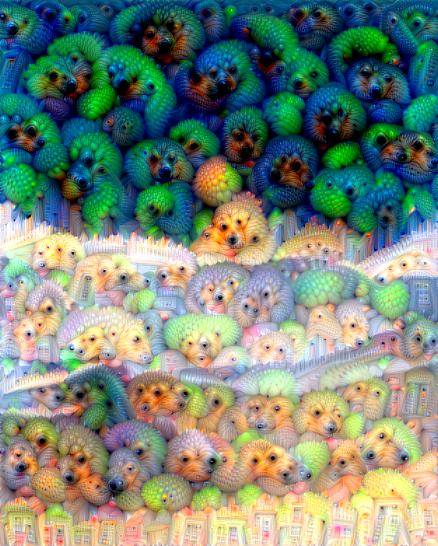

Octave: 2, iter: 45


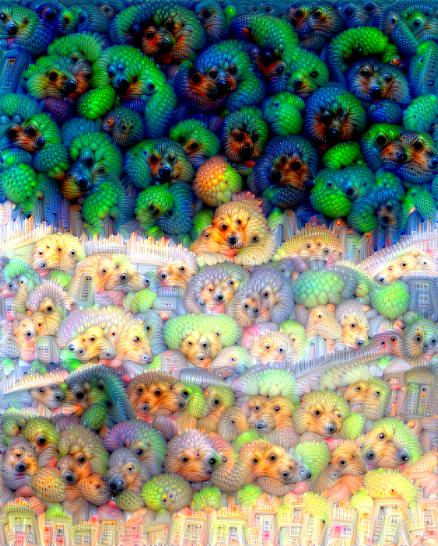

Octave: 2, iter: 60


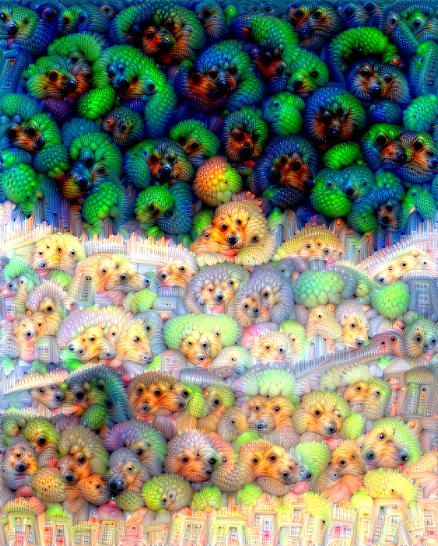

In [52]:
target_img = PIL.Image.open('img/shore.jpg')
target_tensor = img_transform(target_img).unsqueeze(0)
target_np = target_tensor.numpy()

sliced = SlicedVGG(vgg)
# sliced = SlicedInception3()
# sliced = SlicedResnet(resnet)

dream(sliced, target_np, lr=0.02, channel=123, end_layer=30, n_iter=65, show_every=15, n_octave=3, octave_scale=1.4)
